# This is a tutorial of using spaVAE for enhancing spatial resolutions of mouse olfactory bulb data

This tutorial was implemented on Macbook Pro M2.

Import modules.

In [1]:
import math, os
from time import time

import torch
from spaVAE import SPAVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import h5py
import scanpy as sc
from preprocess import normalize, geneSelection

Setup parameters.

In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'Rep9_MOB.h5'
        self.select_genes = 0
        self.batch_size = "auto"
        self.maxiter = 2000
        self.train_size = 1
        self.patience = 200
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.noise = 0
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64]
        self.GP_dim = 2
        self.Normal_dim = 8
        self.decoder_layers = [128]
        self.init_beta = 10
        self.min_beta = 4
        self.max_beta = 25
        self.KL_loss = 0.025
        self.num_samples = 1
        self.fix_inducing_points = True
        self.grid_inducing_points = True
        self.inducing_point_steps = 6
        self.inducing_point_nums = None
        self.fixed_gp_params = False
        self.loc_range = 20.
        self.kernel_scale = 20.
        self.model_file = "model.pt"
        self.final_latent_file = "final_latent.txt"
        self.denoised_counts_file = "denoised_counts.txt"
        self.enhanced_counts_file = "enhanced_counts.txt"
        self.num_denoise_samples = 10000
        self.device = "cpu"

args = Args()

Setup inducing points, preprocess count matrix, and build the spaVAE model.

In [3]:
print(args)

data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X']).astype('float64')
loc = np.array(data_mat['pos']).astype('float64')
data_mat.close()

if args.batch_size == "auto":
    if x.shape[0] <= 1024:
        args.batch_size = 128
    elif x.shape[0] <= 2048:
        args.batch_size = 256
    else:
        args.batch_size = 512
else:
    args.batch_size = int(args.batch_size)

print(args)

if args.select_genes > 0:
    importantGenes = geneSelection(x, n=args.select_genes, plot=False)
    x = x[:, importantGenes]
    np.savetxt("selected_genes.txt", importantGenes, delimiter=",", fmt="%i")

scaler = MinMaxScaler()
loc = scaler.fit_transform(loc) * args.loc_range

print(x.shape)
print(loc.shape)

# We provide two ways to generate inducing point, argument "grid_inducing_points" controls whether to choice grid inducing or k-means
# One way is grid inducing points, argument "inducing_point_steps" controls number of grid steps, the resulting number of inducing point is (inducing_point_steps+1)^2
# Another way is k-means on the locations, argument "inducing_point_nums" controls number of inducing points
if args.grid_inducing_points:
    eps = 1e-5
    initial_inducing_points = np.mgrid[0:(1+eps):(1./args.inducing_point_steps), 0:(1+eps):(1./args.inducing_point_steps)].reshape(2, -1).T * args.loc_range
    print(initial_inducing_points.shape)
else:
    loc_kmeans = KMeans(n_clusters=args.inducing_point_nums, n_init=100).fit(loc)
    np.savetxt("location_centroids.txt", loc_kmeans.cluster_centers_, delimiter=",")
    np.savetxt("location_kmeans_labels.txt", loc_kmeans.labels_, delimiter=",", fmt="%i")
    initial_inducing_points = loc_kmeans.cluster_centers_

adata = sc.AnnData(x, dtype="float64")

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

model = SPAVAE(input_dim=adata.n_vars, GP_dim=args.GP_dim, Normal_dim=args.Normal_dim, encoder_layers=args.encoder_layers, decoder_layers=args.decoder_layers,
    noise=args.noise, encoder_dropout=args.dropoutE, decoder_dropout=args.dropoutD,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, N_train=adata.n_obs, KL_loss=args.KL_loss, init_beta=args.init_beta, min_beta=args.min_beta, 
    max_beta=args.max_beta, dtype=torch.float64, device=args.device)

print(str(model))


(236, 2949)
(236, 2)
(49, 2)
SPAVAE(
  (svgp): SVGP(
    (kernel): CauchyKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=2949, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=64, out_features=10, bias=True)
    (enc_var): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
  )
  (dec_mean): Sequential(
    (0): Linear(in_features=128, out_features=2949, bias=True)
    (1): MeanAct()
  )
  (NB_loss): NBLoss()
)


Train the model.

In [4]:
if not os.path.isfile(args.model_file):
    t0 = time()
    model.train_model(pos=loc, ncounts=adata.X, raw_counts=adata.raw.X, size_factors=adata.obs.size_factors,
            lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
            train_size=args.train_size, maxiter=args.maxiter, patience=args.patience, save_model=True, model_weights=args.model_file)
    print('Training time: %d seconds.' % int(time() - t0))
else:
    model.load_model(args.model_file)

Training
Training epoch 1, ELBO:5423.98852708, NB loss:5410.15059060, GP KLD loss:0.11555885, Gaussian KLD loss:1.26823480, noise regularization:0.000000
Current beta 10.033310445684075
Current kernel scale tensor([19.9990])
Training epoch 2, ELBO:5522.78454772, NB loss:5500.59378602, GP KLD loss:0.12458473, Gaussian KLD loss:2.08712414, noise regularization:0.000000
Current beta 10.072034268455292
Current kernel scale tensor([19.9996])
Training epoch 3, ELBO:5298.89846952, NB loss:5273.88729329, GP KLD loss:0.14508380, Gaussian KLD loss:2.33814605, noise regularization:0.000000
Current beta 10.11644333627227
Current kernel scale tensor([20.0004])
Training epoch 4, ELBO:5379.57567779, NB loss:5358.43170791, GP KLD loss:0.15358997, Gaussian KLD loss:1.93646966, noise regularization:0.000000
Current beta 10.161248392870556
Current kernel scale tensor([20.0012])
Training epoch 5, ELBO:5252.98070591, NB loss:5233.18416927, GP KLD loss:0.16670771, Gaussian KLD loss:1.78153092, noise regular

In [5]:
neigh = NearestNeighbors(n_neighbors=2).fit(loc)
nearest_dist = neigh.kneighbors(loc, n_neighbors=2)[0]
small_distance = np.median(nearest_dist[:,1])/4
loc_new1 = np.empty_like(loc)
loc_new2 = np.empty_like(loc)
loc_new3 = np.empty_like(loc)
loc_new4 = np.empty_like(loc)
loc_new1[:] = loc
loc_new2[:] = loc
loc_new3[:] = loc
loc_new4[:] = loc
loc_new1[:,0] = loc_new1[:,0] - small_distance
loc_new1[:,1] = loc_new1[:,1] + small_distance
loc_new2[:,0] = loc_new2[:,0] + small_distance
loc_new2[:,1] = loc_new2[:,1] + small_distance
loc_new3[:,0] = loc_new3[:,0] - small_distance
loc_new3[:,1] = loc_new3[:,1] - small_distance
loc_new4[:,0] = loc_new4[:,0] + small_distance
loc_new4[:,1] = loc_new4[:,1] - small_distance
loc_enhance = np.concatenate((loc_new1, loc_new2, loc_new3, loc_new4, loc), axis=0)

enhanced_latent, enhanced_counts = model.batching_predict_samples(X_test=loc_enhance, X_train=loc, Y_train=adata.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.data_file[:-3]+"_enhanced_latent.txt", enhanced_latent, delimiter=",")
np.savetxt(args.data_file[:-3]+"_"+args.enhanced_counts_file, enhanced_counts, delimiter=",")
np.savetxt(args.data_file[:-3]+"_enhanced_loc.txt", loc_enhance, delimiter=",")

## Plot enhanced counts in R and ggplot2.

In [1]:
rm(list=ls())
library(rhdf5)
library(ggplot2)
library(scater)
library(repr)
options(repr.plot.width=16, repr.plot.height=6)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Warning message:
“package ‘MatrixGenerics’ was built under R version 4.3.1”
Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumE

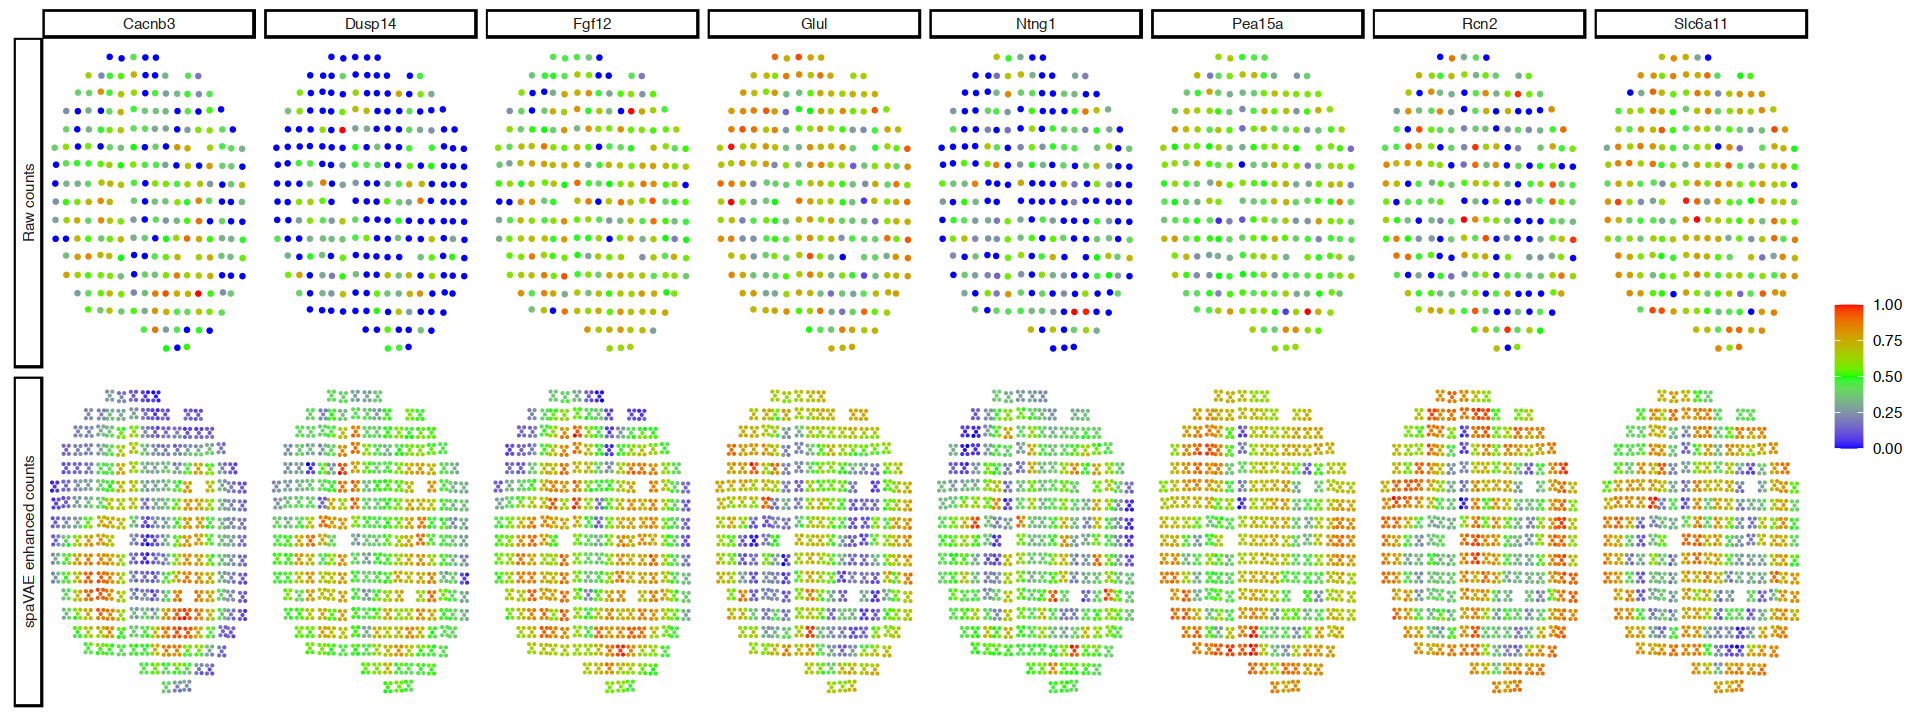

In [2]:
denoise.counts <- read.table("Rep9_MOB_enhanced_counts.txt", sep=",")
genename <- h5read("Rep9_MOB.h5", "gene")
colnames(denoise.counts) <- genename

log.denoise.counts <- log(denoise.counts)
log.denoise.counts <- apply(log.denoise.counts, 2, function(z) scales::rescale(z, to=c(0,1)))

pos <- read.table("Rep9_MOB_enhanced_loc.txt", sep=",")

enhanced.dat <- data.frame(exp=c(log.denoise.counts[, "Cacnb3"], log.denoise.counts[, "Dusp14"], 
                               log.denoise.counts[, "Glul"], log.denoise.counts[, "Rcn2"],
                               log.denoise.counts[, "Ntng1"], log.denoise.counts[, "Pea15a"],
                               log.denoise.counts[, "Fgf12"], log.denoise.counts[, "Slc6a11"]),
                         gene=rep(c("Cacnb3", "Dusp14", "Glul", "Rcn2", "Ntng1", "Pea15a", "Fgf12", "Slc6a11"), each=nrow(pos)),
                         x=rep(pos[,1], 8), y=rep(pos[,2], 8), data="spaVAE enhanced counts")

origin.pos <- t(h5read("Rep9_MOB.h5", "pos"))
origin_pos_x <- scales::rescale(origin.pos[,1], to=c(0,1))*20
origin_pos_y <- scales::rescale(origin.pos[,2], to=c(0,1))*20
origin.pos <- data.frame(V1=origin_pos_x, V2=origin_pos_y)
raw.counts <- h5read("Rep9_MOB.h5", "X")
sce <- SingleCellExperiment(list(counts=as.matrix(raw.counts)))
rownames(sce) <- genename
sce <- logNormCounts(sce, size.factors = sizeFactors(sce))
lograwcounts <- sce@assays@data$logcounts
lograwcounts <- apply(lograwcounts, 1, function(z) scales::rescale(z, to=c(0,1)))

origin.dat <- data.frame(exp=c(lograwcounts[, "Cacnb3"], lograwcounts[, "Dusp14"], 
                             lograwcounts[, "Glul"], lograwcounts[, "Rcn2"],
                             lograwcounts[, "Ntng1"], lograwcounts[, "Pea15a"],
                             lograwcounts[, "Fgf12"], lograwcounts[, "Slc6a11"]),
                       gene=rep(c("Cacnb3", "Dusp14", "Glul", "Rcn2", "Ntng1", "Pea15a", "Fgf12", "Slc6a11"), each=nrow(origin.pos)),
                       x=rep(origin.pos[,1], 8), y=rep(origin.pos[,2], 8), data="Raw counts")

dat <- rbind(enhanced.dat, origin.dat)
size_vector <- c("Raw counts"=0.8, "spaVAE enhanced counts"=0.11)

ggplot(dat, aes(x=x, y=y, color=exp, size=data)) + geom_point() +
scale_size_manual(values=size_vector, guide = "none") +
facet_grid(data~gene, switch="y") + scale_colour_gradientn(colours=rainbow(3, rev=T)) +
theme_classic() +
theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
      legend.title=element_blank())